In [1]:
def plot_real_and_predicted(predictedTime, realTime):
    plt.figure(figsize = (14,8))
    axis = np.arange(realTime.size)
    p1 = plt.scatter(axis, predictedTime, c=predictedTime, cmap='viridis', marker='o', label="Predicted Points")
    p2 = plt.scatter(axis, realTime,  c=realTime, cmap='plasma', marker='x', label="Real Points")
    cb2 = plt.colorbar(p2)
    cb2.ax.set_title('Real Total Time')
    cb1 = plt.colorbar(p1)
    cb1.ax.set_title('Predicted Total Time')
    plt.grid()
    plt.ylim(ymin=0)
    plt.xlabel('Prediction Numer (Num test cases)')
    plt.ylabel('Total Time (sec)')
    plt.legend(loc='upper left')
    plt.draw()
    plt.show()

In [2]:
# Print the varience plot showing differences between real and predicted
def plot_varience(predictedTime, realTime):
    varience = 100 * ((realTime - predictedTime)/realTime)
    plt.figure(figsize = (14,6))
    p1 = plt.scatter(predictedTime, varience, c=realTime, cmap='plasma')
    #p1 = plt.scatter(predictedTime, varience, c=X_test['secondParam'], cmap='plasma')
    cb = plt.colorbar(p1)
    cb.ax.set_title('Real Render Time')
    plt.grid()
    plt.xlim(xmin=0)
    plt.axhline(0, color='black')
    plt.xlabel('Predicted Render Time')
    plt.ylabel('Validation Error %')
    plt.draw()
    plt.show()

In [3]:
def plot_regression_neural_net_metrics(history):
    # plot metrics
    plt.plot(history.history['mean_squared_error'], label="Mean Squared Error")
    plt.plot(history.history['mean_absolute_error'], label="Mean Absolute Error")
    plt.plot(history.history['mean_absolute_percentage_error'], label="Mean Absolute Percentage Error")
    plt.plot(history.history['cosine_proximity'], label="Cosine Proximity")
    plt.legend(loc='upper left')
    plt.grid()
    plt.draw()
    plt.show()

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('raster_cuda_final.csv')

In [6]:
df.info()
#df = df[(df['rank'] == 0)]
#df = df[(df['Cores'] == 1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95580 entries, 0 to 95579
Data columns (total 17 columns):
Cores               95580 non-null int64
Render_composite    95580 non-null float64
Resolution          95580 non-null int64
Base                95580 non-null int64
Camera Angle        95580 non-null int64
Memory Transfer     95580 non-null float64
Init buffer         95580 non-null float64
Cull                95580 non-null float64
Rasterize           95580 non-null float64
Write Surface       95580 non-null float64
Total Render        95580 non-null float64
pixels              95580 non-null int64
actual pixels       95580 non-null int64
objects             95580 non-null int64
rank                95580 non-null int64
frame               95580 non-null int64
 ssp                95580 non-null int64
dtypes: float64(7), int64(10)
memory usage: 12.4 MB


In [7]:
##### From Matt's paper
# Raterization Model -> O + (VO*PPT)
# O -> objects
# VO -> min(AP, O)
# AP -> 55% * 1/numMPiTasks^1/3 * pixels
# PPT -> AP * 4

cores = df['Cores']
objects = df['objects']
pixels = df['pixels']
actualPixels = df ['actual pixels']

activePixels = .55 * (1/cores**(1/3)) * pixels
#visibleObjects = min(activePixels, objects)
#cheat on this for now
visibleObjects = activePixels
ppt = activePixels*4
secondParam = ppt*visibleObjects
secondParam.name = "secondParam"

#tempX = [objects, secondParam, actualPixels, cores]
tempX = [objects, ppt, actualPixels, cores]
X =  pd.DataFrame(tempX)
X = X.T # transpose tow/columns


mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

#X = df[['pixels', 'objects', 'Cores', 'actual pixels']]
y = df['Total Render']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, shuffle=True)

In [10]:
classifiers = [
    #linear_model.SGDRegressor(),
    linear_model.Lasso(),
    linear_model.ElasticNet(),
    linear_model.Ridge(),
    linear_model.LinearRegression(normalize=True)
    ]

***********************************************************
Testing model Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
coef values
[ 0.  0.  0. -0.]


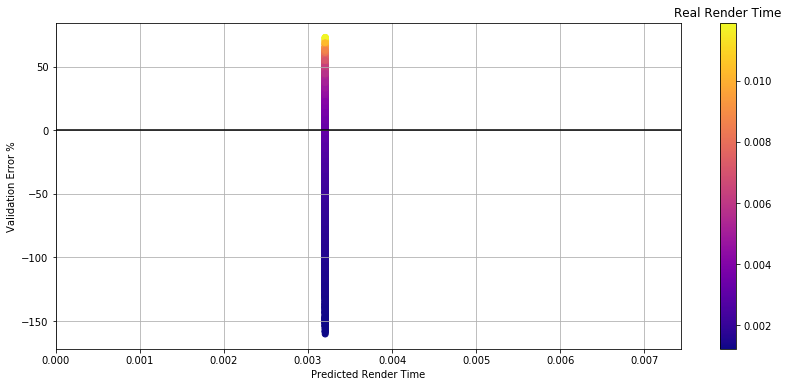

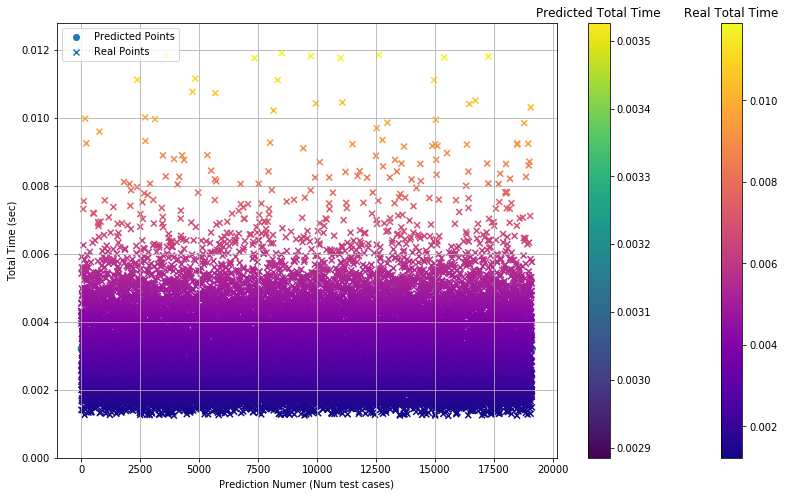


Model score when evaluating the training data
0.0

Model score when evaluating the testing data
-4.179360996836579e-06

Paramater importance to model
objects          0.0
Unnamed 0        0.0
actual pixels    0.0
Cores           -0.0
dtype: float64

R2 Variance Score: -0.00

Cross Validation Scores
[-0.05434398 -0.0044984  -0.02266857]

Accuracy: -0.03 (+/- 0.04)


***********************************************************
Testing model ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
coef values
[ 0.  0.  0. -0.]


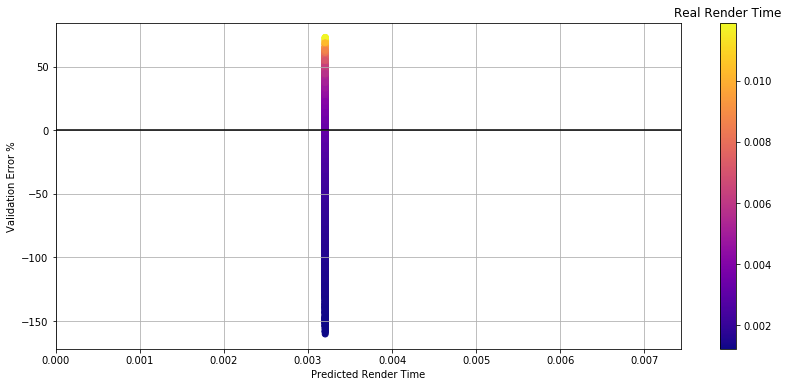

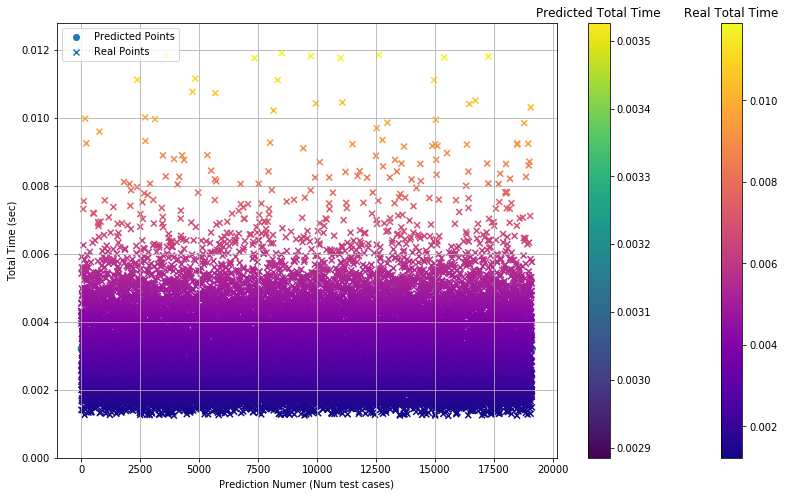


Model score when evaluating the training data
0.0

Model score when evaluating the testing data
-4.179360996836579e-06

Paramater importance to model
objects          0.0
Unnamed 0        0.0
actual pixels    0.0
Cores           -0.0
dtype: float64

R2 Variance Score: -0.00

Cross Validation Scores
[-0.05434398 -0.0044984  -0.02266857]

Accuracy: -0.03 (+/- 0.04)


***********************************************************
Testing model Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
coef values
[ 0.00058836 -0.00050834  0.00129525  0.00026347]


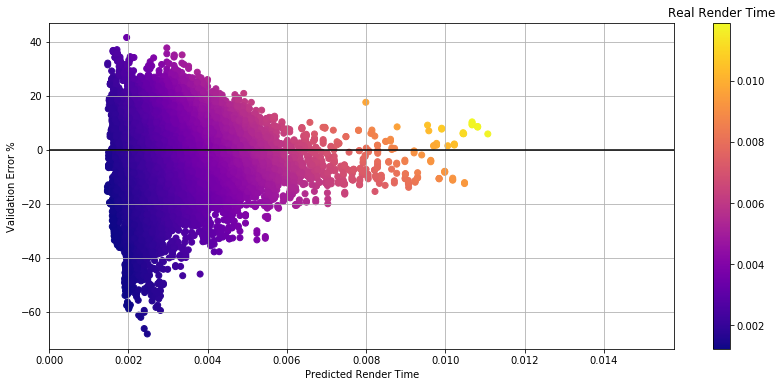

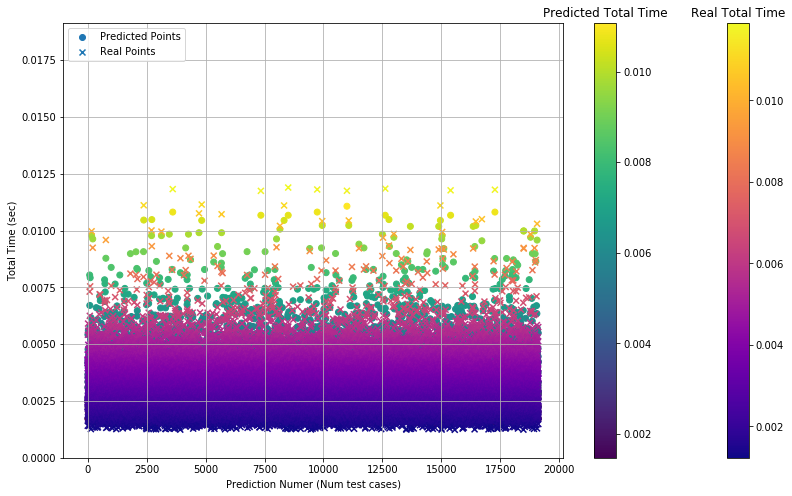


Model score when evaluating the training data
0.8840686767678481

Model score when evaluating the testing data
0.8836688938045036

Paramater importance to model
objects          0.000584
Unnamed 0       -0.000487
actual pixels    0.001275
Cores            0.000263
dtype: float64

R2 Variance Score: 0.88

Cross Validation Scores
[0.88550662 0.87430106 0.85291073]

Accuracy: 0.87 (+/- 0.03)


***********************************************************
Testing model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
coef values
[ 0.00058833 -0.00050854  0.00129547  0.00026348]


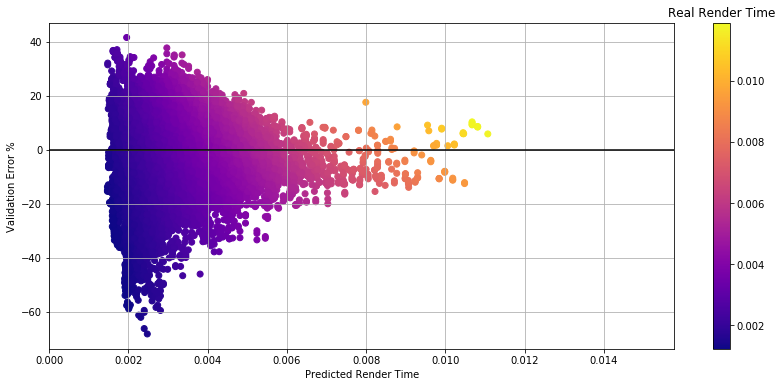

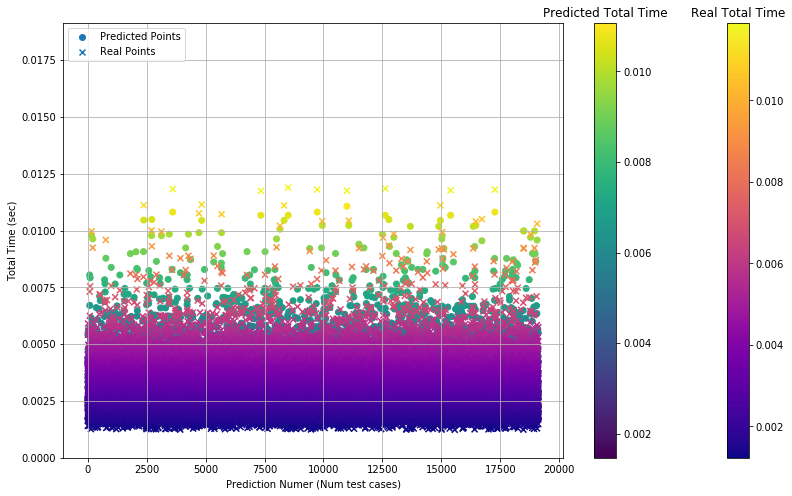


Model score when evaluating the training data
0.8840686799877349

Model score when evaluating the testing data
0.8836689665207015

Paramater importance to model
objects          0.000584
Unnamed 0       -0.000488
actual pixels    0.001275
Cores            0.000263
dtype: float64

R2 Variance Score: 0.88

Cross Validation Scores
[0.88551468 0.87428092 0.85291246]

Accuracy: 0.87 (+/- 0.03)




In [11]:
for item in classifiers:
        print("***********************************************************")
        print("Testing model %s" % item)
        clf = item
        clf.fit(X_train, y_train)
        print("coef values")
        print(clf.coef_)
        pred_test = clf.predict(X_test)
        
        plot_varience(pred_test, y_test)        
        plot_real_and_predicted(pred_test, y_test)
        
        print("\nModel score when evaluating the training data")
        print(clf.score(X_train, y_train))
        print("\nModel score when evaluating the testing data")
        print(clf.score(X_test, y_test))
        
        print("\nParamater importance to model")
        print(np.std(X_test, 0)*clf.coef_)

        # Explained variance score: 1 is perfect prediction
        print('\nR2 Variance Score: %.2f' % r2_score(y_test, pred_test))

        #Do some cross validation with KFold
        scores = cross_val_score(clf, X, y, cv=3)
        print("\nCross Validation Scores")
        print(scores)
        print("\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print("===========================================================")
        print("===========================================================\n\n")

In [12]:
#Look at some simple neural networks
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD, rmsprop
from keras.layers.advanced_activations import ReLU

Using TensorFlow backend.


In [13]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
#model.compile(Adam(lr=0.05), 'binary_crossentropy', metrics=['accuracy'])
model.compile(Adam(lr=0.05), 'mean_squared_error', metrics=[])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, epochs=3, verbose=1)

Epoch 1/3
76464/76464 [==============================] - 9s 121us/step - loss: 5.6994e-04
Epoch 2/3
76464/76464 [==============================] - 8s 106us/step - loss: 5.7408e-07
Epoch 3/3
76464/76464 [==============================] - 8s 105us/step - loss: 1.7707e-06


In [16]:
results = model.evaluate(X_test, y_test)

19116/19116 [==============================] - 1s 36us/step


In [17]:
currentPrediction = model.predict(X_test)

In [18]:
currentPrediction = currentPrediction.reshape(currentPrediction.size)
currentPrediction.shape

(19116,)

In [19]:
y_test.shape

(19116,)

In [20]:
#print("First firstPrediction/real: %f/%f " % (currentPrediction[0], y_test[0]))

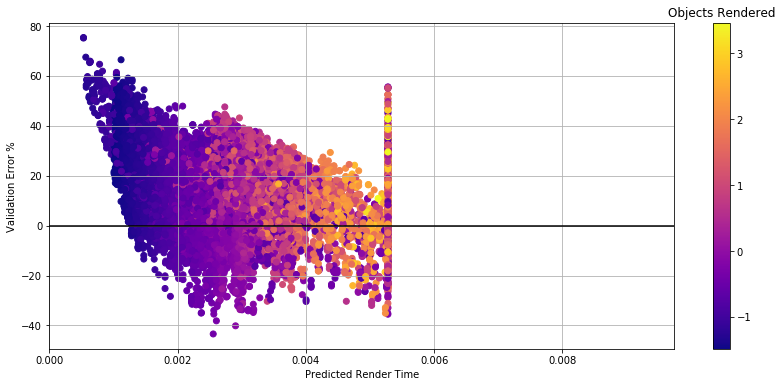

In [21]:
# Print the plot showing differences between real and predicted
varience = 100 * ((y_test - currentPrediction)/y_test)
plt.figure(figsize = (14,6))
p1 = plt.scatter(currentPrediction, varience, c=X_test['objects'], cmap='plasma')
#p1 = plt.scatter(pred_test, varience, c=X_test['secondParam'], cmap='plasma')
cb = plt.colorbar(p1)
cb.ax.set_title('Objects Rendered')
plt.grid()
plt.xlim(xmin=0)
plt.axhline(0, color='black')
plt.xlabel('Predicted Render Time')
plt.ylabel('Validation Error %')
plt.draw()
plt.show()

In [22]:
# Explained variance score: 1 is perfect prediction
print('\nR2 Variance Score: %.2f' % r2_score(y_test, currentPrediction))


R2 Variance Score: 0.64


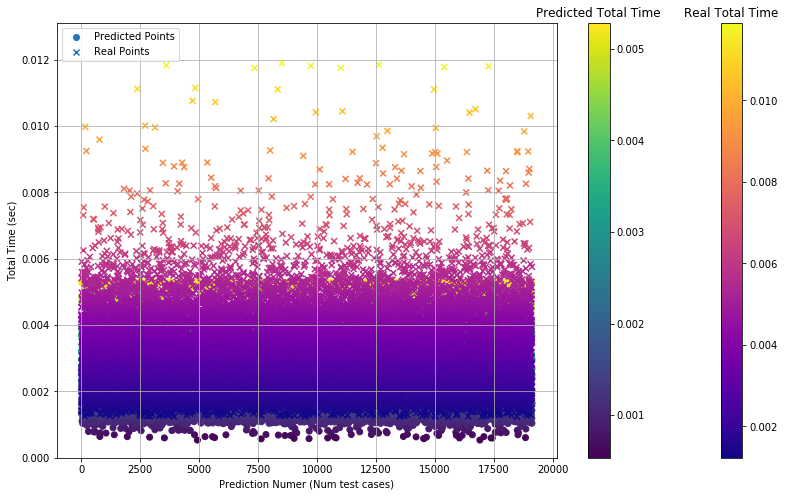

In [23]:
plot_real_and_predicted(currentPrediction, y_test)

In [24]:
import wandb
from wandb.keras import WandbCallback
#wandb.init()
#config = wandb.config
#config.layer_1_size  = 1024
#config.layer_2_size = 512
#config.dropout = 0.2
#config.learn_rate = 0.001
#config.epochs = 10
#config.batch_size=256
#config.activation='relu'

In [25]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, shuffle=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from matplotlib import pyplot
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='mean_squared_error', patience=20, verbose=1)

#wandb.monitor()
# create model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae', 'mape', 'cosine'])
history = model.fit(X_train, y_train, epochs=5, verbose=1, callbacks=[early_stop])


Epoch 1/5
76464/76464 [==============================] - 23s 300us/step - loss: 1.7825e-04 - mean_squared_error: 1.7825e-04 - mean_absolute_error: 0.0051 - mean_absolute_percentage_error: 168.8591 - cosine_proximity: -0.5865
Epoch 2/5
76464/76464 [==============================] - 22s 282us/step - loss: 3.4366e-06 - mean_squared_error: 3.4366e-06 - mean_absolute_error: 0.0013 - mean_absolute_percentage_error: 44.1290 - cosine_proximity: -0.9060
Epoch 3/5
26912/76464 [=========>....................] - ETA: 14s - loss: 8.1327e-07 - mean_squared_error: 8.1327e-07 - mean_absolute_error: 6.9203e-04 - mean_absolute_percentage_error: 23.2428 - cosine_proximity: -0.9999

In [ ]:
model.summary()

In [ ]:
plot_regression_neural_net_metrics(history)

In [ ]:
currentPrediction = model.predict(X_test)

In [ ]:
currentPrediction = currentPrediction.reshape(currentPrediction.size)
currentPrediction.shape

In [ ]:
plot_varience(currentPrediction, y_test)

In [ ]:
y_test.shape

In [ ]:
currentPrediction.shape

In [ ]:
currentPrediction[0]

In [ ]:
#y_test[0]

In [ ]:
# Explained variance score: 1 is perfect prediction
print('\nR2 Variance Score: %.2f' % r2_score(y_test, currentPrediction))

In [ ]:
plot_real_and_predicted(currentPrediction, y_test)